In [6]:
#instllations
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

import re
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from transformers import *
import shutil
from nltk.corpus import stopwords
from official.nlp import optimization  
from sklearn.model_selection import train_test_split
import random
from wordcloud import WordCloud, STOPWORDS
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [9]:
#read dataset
df = pd.read_csv('/content/drive/MyDrive/Project/python/Hate_speech/labeled_data.csv')
df = df[['class',	'tweet']]

#map target 
df['label'] = df['class'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df.head()

,class,tweet,label
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


##Data Preparation

In [10]:
#remove stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.append('RT')
def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if not word in stop_words])
df['tweet'] = df['tweet'].apply(remove_stopwords)


#remove usernmaes
df['tweet'].replace(r'@\w+','',regex=True,inplace=True)

#remove urls
df['tweet'].replace(r'http\S+','',regex=True,inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
#remove hashtags
def remove_hashsymbols(text):
    pattern = re.compile(r'#')
    clean_text = re.sub(pattern,'',text)
    return clean_text
df['tweet'] = df['tweet'].apply(remove_hashsymbols)

#remove digits
def rem_digits(text):
    no_digits = []
    for word in text.split(' '):
        no_digits.append(re.sub(r'\d','',word))
    return ' '.join(no_digits) 
df['tweet'] = df['tweet'].apply(rem_digits)
  
#remove non alphnumeric
def rem_nonalpha(text):
    text = ' '.join([word for word in text.split(' ') if word.isalpha()])
    return text
df['tweet'] = df['tweet'].apply(rem_nonalpha)

#lowercase
df['tweet'] = df['tweet'].apply(lambda x : x.lower())

In [12]:
df.head()

,class,tweet,label
0,2,as woman complain cleaning man always take trash,neither
1,1,boy dats dwn bad cuffin dat hoe st,offensive_language
2,1,you ever fuck bitch start you confused shit,offensive_language
3,1,look like tranny,offensive_language
4,1,the shit hear might true might faker bitch tol...,offensive_language


<Axes: xlabel='label', ylabel='count'>

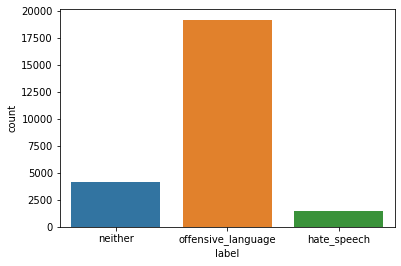

In [19]:
#count of targets
sns.countplot(data=df, x='label')

In [20]:
#split the data into train-test-val in the ration 80:10:10
X_train_, X_test, y_train_, y_test = train_test_split(df.index.values, df['class'].values, test_size=0.10, random_state=42, 
                                                      stratify=df['class'].values)

X_train, X_val, y_train, y_val = train_test_split(df.loc[X_train_].index.values, df.loc[X_train_]['class'].values,test_size=0.10,
    random_state=42, stratify=df.loc[X_train_]['class'].values,  
)

In [21]:
#stopwords 
stopwords = set(STOPWORDS)
stopwords.add("RT")

In [22]:
#wordcloud generation
def wordcloud_template(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


def Wordcloud_test(target):
  wordcloud = WordCloud(background_color='cyan',
                            stopwords=stopwords,
                            max_words=400,
                            max_font_size=40, 
                            random_state=42
                          ).generate(str(df.loc[df["label"]==target].tweet))
  return wordcloud

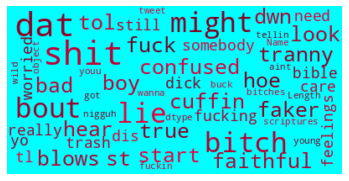

In [23]:
# offensive_language wordcloud

wordcloud = Wordcloud_test("offensive_language")
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= wordcloud_template, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()


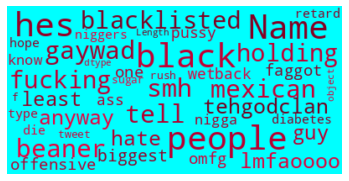

In [24]:
# hate_speech wordcloud

wordcloud = Wordcloud_test("hate_speech")
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= wordcloud_template, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()


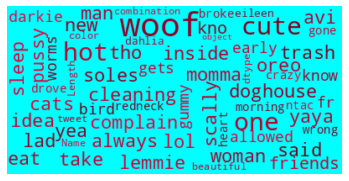

In [25]:
# hate_speech wordcloud

wordcloud = Wordcloud_test("neither")
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= wordcloud_template, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()


In [26]:
#create data tensor
train_ds = tf.data.Dataset.from_tensor_slices((df.loc[X_train].tweet.values, df.loc[y_train]['class'].values))
val_ds = tf.data.Dataset.from_tensor_slices((df.loc[X_val].tweet.values, df.loc[y_val]['class'].values))
test_ds = tf.data.Dataset.from_tensor_slices((df.loc[X_test].tweet.values, df.loc[y_test]['class'].values))

In [27]:
#shuffle the data into batches
train_ds = train_ds.shuffle(X_train.shape[0]).batch(32, drop_remainder=False)
val_ds = val_ds.shuffle(X_val.shape[0]).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(X_test.shape[0]).batch(32, drop_remainder=False)

In [28]:
#print sample
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

Tweet: b'really asked dead ass serious could say lol'
Label : 1


#Modeling

In [30]:
#bert model pre-trained weights
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1'

#pre-processsing layer
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

#bert model
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [62]:
#due to data imblace add weights
class_weight = {0: 1-0.06, 1: 1-0.77, 2: 1-0.17}

In [63]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        #print(output_bias)
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(128, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)


#create model object
classifier_model = build_classifier_model(output_bias=np.array([3.938462, 15, 5.]))

#losses and metrics
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [64]:
#model summary
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

#Training

In [65]:
#compile model with adamw optimizer

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#dont execute

In [66]:
#train model
history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weight)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


628/628 [==============================] - 168s 255ms/step - loss: 0.1464 - accuracy: 0.9272 - val_loss: 0.2054 - val_accuracy: 0.9346
Epoch 2/5
628/628 [==============================] - 157s 250ms/step - loss: 0.0991 - accuracy: 0.9249 - val_loss: 0.2040 - val_accuracy: 0.9301
Epoch 3/5
628/628 [==============================] - 159s 253ms/step - loss: 0.0847 - accuracy: 0.9341 - val_loss: 0.2133 - val_accuracy: 0.9256
Epoch 4/5
628/628 [==============================] - 157s 250ms/step - loss: 0.0722 - accuracy: 0.9442 - val_loss: 0.2056 - val_accuracy: 0.9377
Epoch 5/5
628/628 [==============================] - 156s 248ms/step - loss: 0.0632 - accuracy: 0.9511 - val_loss: 0.2247 - val_accuracy: 0.9332


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


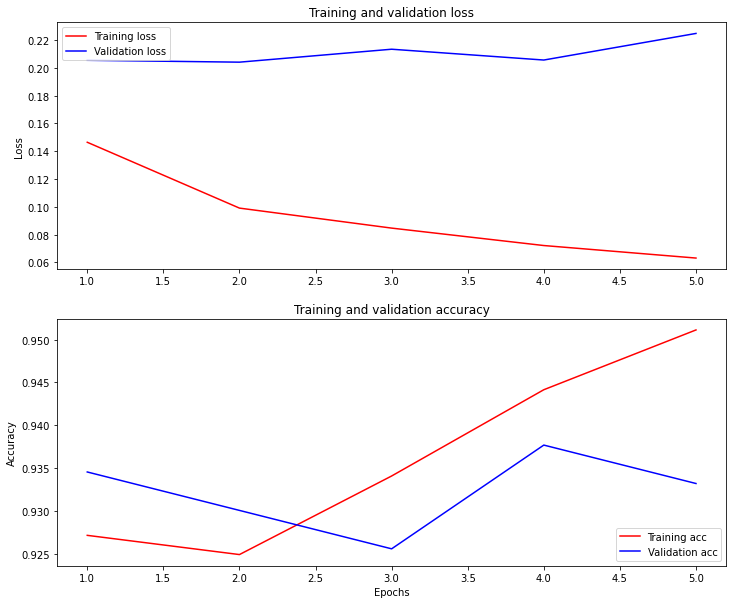

In [67]:
#model training history
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [68]:
#save model weights
saved_model_path = '/content/drive/MyDrive/Hate Speech Detection/saved_model'
classifier_model.save(saved_model_path, include_optimizer=False)

# **start execution**

#Evaluate model

In [69]:
#load model weights
saved_model_path = '/content/drive/MyDrive/Project/python/Hate_speech/saved_model'

loaded_trained_model = keras.models.load_model(saved_model_path)


#losses and metrics
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
loaded_trained_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#evaluate model's performance on the test set
_, accuracy = loaded_trained_model.evaluate(test_ds)
print(f'Test, Accuracy: {accuracy}')

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


78/78 [==============================] - 12s 140ms/step - loss: 0.2344 - accuracy: 0.9177
Test, Accuracy: 0.9177087545394897


In [70]:
def pre_process_Text(x):
  x = remove_stopwords(x)
  x = x.replace(r'@\w+','')
  x = x.replace(r'http\S+','')

  x = remove_hashsymbols(x)
  x = rem_digits(x)
  x = rem_nonalpha(x)
  x = x.lower()
  return x

In [71]:
#predict label of given text
input_ = """"@djsliime: That long distance shit wack I knew the bitch was cheating"- uh oh"""

input_ = pre_process_Text(input_)
print('input:', input_)
output = np.argmax(loaded_trained_model.predict([input_], verbose=False), axis=1)

class_mapping = {0: 'hate_speech', 1: 'offensive_language',2: 'neither'}
print('Prediction: ', class_mapping[output[0]])


input: that long distance shit wack i knew bitch uh oh
Prediction:  offensive_language


In [72]:
#predict label of given text
input_ = """"how u gone bring ur side bitch game you know ya gf friends i"""

input_ = pre_process_Text(input_)
print('input:', input_)
output = np.argmax(loaded_trained_model.predict([input_], verbose=False), axis=1)

class_mapping = {0: 'hate_speech', 1: 'offensive_language',2: 'neither'}
print('Prediction: ', class_mapping[output[0]])

input: u gone bring ur side bitch game know ya gf friends
Prediction:  offensive_language


In [73]:
#predict label of given text
input_ = """"gone broke wrong heart drove redneck crazy"""

input_ = pre_process_Text(input_)
print('input:', input_)
output = np.argmax(loaded_trained_model.predict([input_], verbose=False), axis=1)

class_mapping = {0: 'hate_speech', 1: 'offensive_language',2: 'neither'}
print('Prediction: ', class_mapping[output[0]])

input: broke wrong heart drove redneck crazy
Prediction:  offensive_language
